In [94]:
import numpy as np
from PIL import Image, ImageColor, ImageDraw, ImageFont
from requests import post

from classes import classes

In [10]:
# this function is from yolo3.utils.letterbox_image
def letterbox_image(image, size):
    '''resize image with unchanged aspect ratio using padding'''
    iw, ih = image.size
    w, h = size
    scale = min(w/iw, h/ih)
    nw = int(iw*scale)
    nh = int(ih*scale)

    image = image.resize((nw, nh), Image.BICUBIC)
    new_image = Image.new('RGB', size, (128, 128, 128))
    new_image.paste(image, ((w-nw)//2, (h-nh)//2))
    return new_image


def preprocess(img):
    model_image_size = (416, 416)
    boxed_image = letterbox_image(img, tuple(reversed(model_image_size)))
    image_data = np.array(boxed_image, dtype='float32')
    image_data /= 255.
    image_data = np.transpose(image_data, [2, 0, 1])
    image_data = np.expand_dims(image_data, 0)
    return image_data

In [136]:
img_path = './sample-images/cat.jpg'
image = Image.open(img_path)
# input
image_data = preprocess(image)
image_size = np.array([image.size[1], image.size[0]], dtype=np.float32).reshape(1, 2)

/tmp/ipykernel_622/3469868544.py:10: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  image = image.resize((nw,nh), Image.BICUBIC)


In [12]:
image_size

array([[ 715., 1024.]], dtype=float32)

In [111]:
def detect_objects(image, prediction_url, token):
    payload = _serialize(image)
    model_response = _get_model_response(payload, prediction_url, token)
    boxes, scores, class_indices = _postprocess(model_response)
    return boxes, scores, class_indices


def _serialize(image):
    payload = {
        'inputs': [
            {
                'name': 'input_1',
                'shape': [1, 3, 416, 416],
                'datatype': 'FP32',
                'data': image.flatten().tolist(),
            },
            {
                'name': 'image_shape',
                'shape': [1, 2],
                'datatype': 'FP32',
                'data': [416, 416],
            },
        ]
    }
    return payload


def _get_model_response(payload, prediction_url, token):
    headers = {'Authorization': f'Bearer {token}'}
    raw_response = post(prediction_url, json=payload, headers=headers)
    try:
        response = raw_response.json()
    except:
        print(f'Failed to deserialize service response.\n'
              f'Status code: {raw_response.status_code}\n'
              f'Response body: {raw_response.text}')
    try:
        model_output = response['outputs']
    except:
        print(f'Failed to extract model output from service response.\n'
              f'Service response: {response}')
    return model_output


def _postprocess(model_response):
    raw_boxes, raw_scores, raw_class_indices = model_response
    boxes = _unpack(raw_boxes)
    scores = _unpack(raw_scores)
    class_indices = _unpack(raw_class_indices)
    return boxes, scores, class_indices


def _unpack(response_item):
    return np.array(response_item['data']).reshape(response_item['shape'])

In [137]:
model_name = 'tiny-yolo'
endpoint = 'http://modelmesh-serving.object-detection:8008'
prediction_url = f'{endpoint}/v2/models/{model_name}/infer'

boxes, scores, class_indices = detect_objects(
    image_data, prediction_url, token=''
)

In [117]:
boxes.shape

(1, 2535, 4)

In [138]:
out_boxes, out_scores, out_classes = [], [], []
for idx_ in class_indices[0]:
    out_classes.append(classes[idx_[1]])
    out_scores.append(scores[tuple(idx_)])
    idx_1 = (idx_[0], idx_[2])
    out_boxes.append(boxes[idx_1])

In [119]:
out_boxes

[array([195.13216 ,   4.980468, 352.3464  ,  84.79811 ]),
 array([120.61727, 284.56903, 231.32141, 344.57675]),
 array([208.38815, 254.4596 , 341.5735 , 344.6384 ]),
 array([197.47163, 156.07141, 348.8979 , 262.6553 ]),
 array([ 70.03263, 324.82562, 196.18475, 390.7178 ]),
 array([ 70.908585 ,   0.2370143, 193.39374  ,  77.209045 ]),
 array([210.99069, 326.52872, 336.68835, 418.65024]),
 array([141.93404, 232.18301, 265.6217 , 287.27686]),
 array([206.04128,  75.27021, 347.02814, 174.01889]),
 array([ 96.26222, 280.02423, 194.67558, 338.89404]),
 array([132.7775 , 333.85324, 233.60455, 404.49664])]

In [120]:
out_scores

[0.9590069,
 0.89534754,
 0.854671,
 0.81682825,
 0.79996127,
 0.79897493,
 0.7851823,
 0.7539488,
 0.7265756,
 0.6682922,
 0.6500255]

In [139]:
out_classes

['cat']

In [104]:
def draw_bounding_box_on_image(
        image, ymin, xmin, ymax, xmax, color, font,
        thickness=4, display_str_list=()):
    """Adds a bounding box to an image."""
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    width_scaling_factor = im_width / 416
    height_scaling_factor = im_height / 416
    (left, right, top, bottom) = (
        xmin * width_scaling_factor,
        xmax * width_scaling_factor,
        ymin * height_scaling_factor,
        ymax * height_scaling_factor,
    )
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
               (left, top)], width=thickness, fill=color)
    # print(f'(left, right, top, bottom): ({left}, {right}, {top}, {bottom})')

    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)
    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height

    for display_str in display_str_list[::-1]:
        # print(f'display_str: {display_str}')
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)], fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str, fill="black", font=font)
        text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, scores, classes):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    colors = list(ImageColor.colormap.values())
    class_colors = {}
    font = ImageFont.load_default()
    image_pil = Image.open(image)

    for index, class_ in enumerate(classes):
        box = boxes[index]
        display_str = f'{class_}: {int(100 * scores[index])}%'
        if class_ not in class_colors:
            class_colors[class_] = colors[hash(class_) * 4 % len(colors)]
        color = class_colors.get(class_)
        # print(f'index: {index}, box: {box}, color: {color}, display_str: {display_str}')
        draw_bounding_box_on_image(
            image_pil, box[0], box[1], box[2], box[3], color, font,
            display_str_list=[display_str]
        )
    return image_pil
    image_pil.show()

/tmp/ipykernel_622/4233776220.py:19: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
/tmp/ipykernel_622/4233776220.py:28: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_width, text_height = font.getsize(display_str)


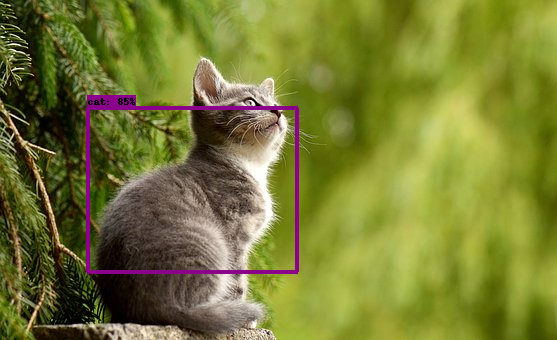

In [140]:
draw_boxes(img_path, out_boxes, out_scores, out_classes)